# 用python绘制樱花开放

## 项目简介
两周前刷上热搜的用代码绘制武大樱花开放，被广泛分享转发

<img src="imgs/src_frame_0001.jpg">
<img src="imgs/gen_frame_0001.jpg" width=150%>

## 制作原因
过去两年是武大官方微博的小编，每年樱花季都会做一些策划。去年做了一个#分专业表白樱花#，当时的效果还不错，于是今年退休之后小伙伴又找到我，希望我再用代码制作一个樱花相关的视频，结合前段时间武汉的疫情，就想到了用文字画的形式绘制武大樱花的开放。

<img style="float: left" src="imgs/sakura_1.jpg" width=40%><img src="imgs/sakura_2.jpg" width=58%>
## 实现思路
1. 读取源视频文件，进行抽帧保存为源图片
2. 以文字为像素点新建图片
3. 对每一张源图片的像素信息进行提取，赋给新建的图片
4. 将新建图片逐帧合成，得到新视频

***
### 导入需要的python模块
cv2: OpenCV是一个基于BSD许可（开源）发行的跨平台计算机视觉库——在本项目中用于视频和图片的读取
<br/>
PIL：Python Imaging Library，是Python平台的图像处理库——在本项目中用于新的文字版图片的绘制

In [1]:
import os
import cv2
import time
import numpy as np
from glob import glob
from PIL import Image, ImageDraw, ImageFont

### 准备所需字体
本案例使用的是开源无版权的字体[SourceHanSerifSC_SB-H.zip](https://github.com/adobe-fonts/source-han-serif/raw/release/OTF/SourceHanSerifSC_SB-H.zip)，该压缩包解压后可在其中找到SourceHanSerifSC-Bold.otf字库文件。

字库已经上传到了本案例的font目录下

In [2]:
if not os.path.exists('font/SourceHanSerifSC-Bold.otf'):
    raise Exception('字库文件不存在，请上传')

### 指定各项输入输出的路径

In [3]:
draw_text = "武汉加油"              # 需要绘制的文字
src_video_path = 'video/video.avi'  # 源视频所在的路径
video_frames_dir = 'frames'         # 从源视频提取的每帧图片保存路径
gen_img_dir = "gen_imgs"            # 生成图片的保存目录
font_path = 'font/SourceHanSerifSC-Bold.otf'
gen_video_path = src_video_path.split('.', -1)[0] + '_gen.mp4'  # 生成视频的保存路径
if not os.path.exists(video_frames_dir):
    os.mkdir(video_frames_dir)
if not os.path.exists(gen_img_dir):
    os.mkdir(gen_img_dir)

## 代码块1——视频抽帧

基本思路：读取源视频，逐帧抽取为图片，以便之后的处理

processing 100
processing 200
processing 300
processing 400
processing 500
processing 600
processing 700
total image count 713
end


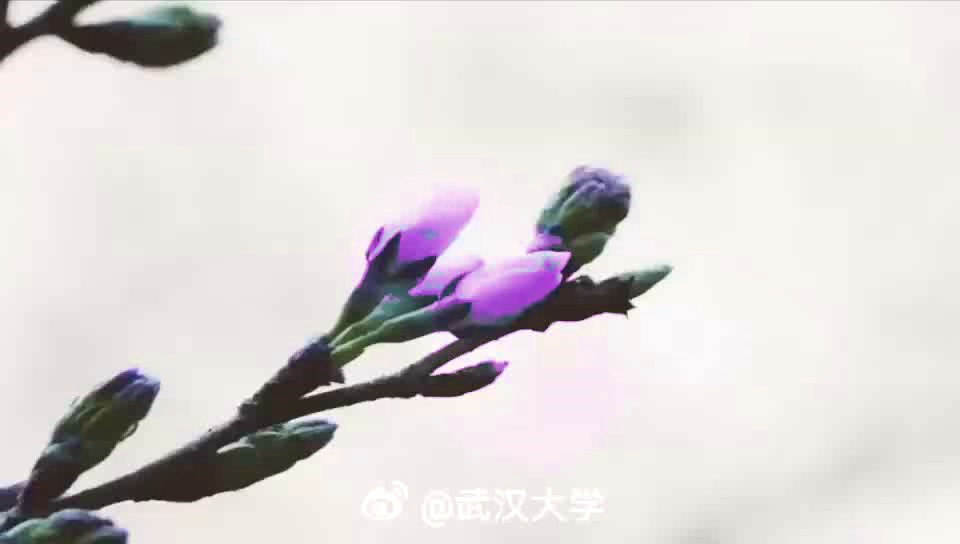

In [4]:
vidcap = cv2.VideoCapture(src_video_path) 
count = 0
success = True
while success:
    success,frame = vidcap.read() # 返回读取成功与否的布尔值和图像信息
    cv2.imwrite(os.path.join(video_frames_dir, "frame_%04d.jpg" % count), frame)  # 将读取到的图片保存到video_frames文件夹
    count += 1
    if count % 100 == 0:
        print('processing', count)
print('total image count', count)
print('end')
Image.fromarray(cv2.imread(os.path.join(video_frames_dir, "frame_%04d.jpg" % 1)))  # 显示第一张图片

## 代码块2——绘制包含文字的图片底板
基本思想：创建全黑背景图，首先在一行中写满文字，再逐行复制直至填充满整个图片

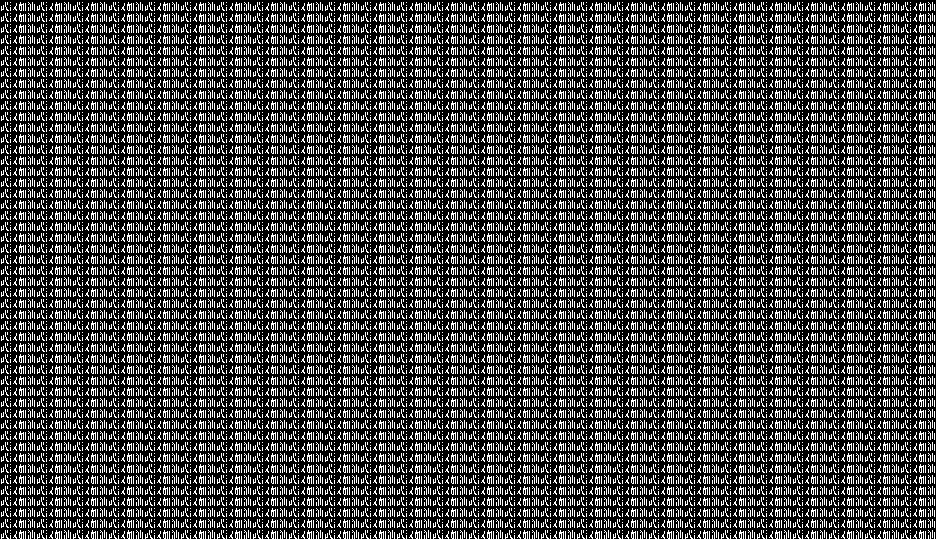

In [5]:
img = cv2.imread('frames/frame_0001.jpg')  # 读取原图
text_size = 9 #设置文字的大小，太小会糊，太大会看不清图案
font = ImageFont.truetype(font_path, size=text_size)  # 读取字库

blank = Image.new("RGB", [len(draw_text) * text_size, text_size+2], color=(0, 0, 0))  # 创建全黑色背景图，上下各空出一个像素，防止文字重叠
drawObj = ImageDraw.Draw(blank)
drawObj.text([0, 0], draw_text, fill=(1, 1, 1), font=font)  # 在全黑色图上写文字，文字的三个通道像素值全为1，第一个参数为文字的起始坐标(x, y)
blank = np.array(blank) # 将像素信息转为三维数组，方便后续处理

text_block_width = blank.shape[1]
text_block_height = blank.shape[0]
row_n = int(img.shape[1] / text_block_width)   # 水平方向上总共有row_n个“武汉加油”文字块
col_n = int(img.shape[0] / text_block_height)  # 竖直方向上总共有col_n个
row_array = blank
for i in range(row_n - 1): # 减1是为了防止拼接出的文字图比原图片大
    row_array = np.hstack((row_array, blank))  # 拼接成一行文字块(np.hstack方法可以理解为按行拼接)
text_img_array = row_array
for j in range(col_n - 1): # 同上原因
    text_img_array = np.vstack((text_img_array, row_array))  # 多行文字块拼接成一幅文字块图像
text_img_array*=255 # 将前景色为1的文字转为白色，以看清文字
Image.fromarray(text_img_array)  # 显示文字块图

# 代码块3——根据源图片的像素信息改变文字的颜色
基本思路：将源图片缩放至与文字图片相同的大小，将每个文字对应部分的图像块颜色赋给文字，使得生成的图片拥有和源图片相同的色彩

### 方法1：直接使用 ImageDraw.Draw.text 函数在一张空白图上逐行逐列写字
这种方法很好理解，但是效率很低，耗时长

In [6]:
# 绘制文字图的方法1
def draw(pic):
    img = cv2.imread(video_frames_dir + '/' + pic)
    blank = Image.new("RGB", [img.shape[1], img.shape[0]], "white")
    drawObj = ImageDraw.Draw(blank)

    n = 10 # 读取像素的间隔（源图片分辨率太高了最后生成的文字会有重叠）
    m = 9 # 

    font = ImageFont.truetype(font_path, size=m)

    t1 = time.time()
    for i in range(0, img.shape[0], n):
        for j in range(0, img.shape[1], n):
            drawObj.text([j, i], draw_text[int(j / n) % len(draw_text)], fill=(img[i][j][2], img[i][j][1], img[i][j][0]), font=font) # 按句子的顺序填充文字
    print('cost time %.3f s' % (time.time() - t1))

    blank.save(gen_img_dir + '/' + pic) # 保存生成的图片


filelist = os.listdir(video_frames_dir)

n = 1

for file in filelist[:5]:
    try:
        draw(file)
        print('finish %d/%d'%(n, len(filelist)))
    except Exception as e:
        print('error %d'%n, e)
    n+=1

cost time 0.950 s
finish 1/713
cost time 0.981 s
finish 2/713
cost time 0.967 s
finish 3/713
cost time 0.960 s
finish 4/713
cost time 0.943 s
finish 5/713


### 方法2：先生成一个文字块，再逐行逐列拼接文字块，最后给所有文字块注意赋予像素值
这种方法难理解一些，但是速度更快

In [7]:
# 绘制文字图的方法2
def draw_img(src_img_path, dst_img_dir, text="", text_size=9, font_file_path=""):
    img = cv2.imread(src_img_path)  # 读取原图
    font = ImageFont.truetype(font_file_path, size=text_size)  # 读取字库

    blank = Image.new("RGB", [len(text) * text_size, text_size + 2], color=0)  # 创建全黑色背景图，上下各多给出1像素
    drawObj = ImageDraw.Draw(blank)
    drawObj.text([0, 0], text, fill=(1, 1, 1), font=font)  # 在全黑色图上写文字，文字的三个通道像素值全为1，第一个参数为文字的起始坐标(x, y)
    blank = np.array(blank)

    text_block_width = blank.shape[1]
    text_block_height = blank.shape[0]
    row_n = int(img.shape[1] / text_block_width)  # 水平方向上总共有row_n个文字块
    col_n = int(img.shape[0] / text_block_height)  # 竖直方向上总共有col_n个
    row_array = blank
    for i in range(row_n - 1):# 减1是为了防止拼接出的文字图比原图片大
        row_array = np.hstack((row_array, blank))  # 拼接成一行文字块
    text_img_array = row_array
    for j in range(col_n - 1):
        text_img_array = np.vstack((text_img_array, row_array))  # 多行文字块拼接成一幅文字块图像

    img_resize = cv2.resize(img, (text_img_array.shape[1], text_img_array.shape[0]))  # 将原图缩放成文字块图像相同的尺寸
    # 逐个汉字赋予新的像素值
    text_width = int(text_block_width / len(draw_text))
    text_height = text_block_height
    row_text_num = int(img_resize.shape[1] / text_width)  # 水平方向上总共有row_text_num个文字
    col_text_num = int(img_resize.shape[0] / text_height)  # 竖直方向上总共有col_text_num个
    for i in range(row_text_num):
        for j in range(col_text_num):
            x1 = i * text_width
            x2 = x1 + text_width
            y1 = j * text_height
            y2 = y1 + text_height
            one_text_block = text_img_array[y1:y2, x1:x2, :]  # 获取单个汉字的文字块
            img_block = img_resize[y1:y2, x1:x2, :]  # 获取原图上对应单个汉字的图像块
            for chanel in range(3):
                color = int(np.mean(img_block[:, :, chanel]))  # 计算原图图像块单个通道的像素均值
                one_text_block[:, :, chanel] *= color  # 将单个汉字文字块中像素为1的值全变成像素均值

    text_img_array[text_img_array == 0] = 255  # 将文字块图像全黑的地方变成全白
    cv2.imwrite(os.path.join(dst_img_dir, os.path.basename(src_img_path)), text_img_array)


filelist = glob(os.path.join(video_frames_dir, '*.jpg'))

n = 1
for i, file_path in enumerate(filelist):
    try:
        t1 = time.time()
        draw_img(file_path, gen_img_dir, draw_text, text_size=9, font_file_path=font_path)
        print('process %d/%d, cost time %.3f s' % (len(filelist), i + 1, time.time() - t1))
    except Exception as e:
        print('error %d' % n, e)
    n += 1

process 713/1, cost time 0.252 s
process 713/2, cost time 0.249 s
process 713/3, cost time 0.245 s
process 713/4, cost time 0.247 s
process 713/5, cost time 0.245 s
process 713/6, cost time 0.246 s
process 713/7, cost time 0.251 s
process 713/8, cost time 0.250 s
process 713/9, cost time 0.246 s
process 713/10, cost time 0.246 s
process 713/11, cost time 0.247 s
process 713/12, cost time 0.249 s
process 713/13, cost time 0.244 s
process 713/14, cost time 0.244 s
process 713/15, cost time 0.251 s
process 713/16, cost time 0.249 s
process 713/17, cost time 0.249 s
process 713/18, cost time 0.247 s
process 713/19, cost time 0.250 s
process 713/20, cost time 0.249 s
process 713/21, cost time 0.246 s
process 713/22, cost time 0.245 s
process 713/23, cost time 0.255 s
process 713/24, cost time 0.251 s
process 713/25, cost time 0.253 s
process 713/26, cost time 0.248 s
process 713/27, cost time 0.250 s
process 713/28, cost time 0.267 s
process 713/29, cost time 0.258 s
process 713/30, cost ti

## 改进前后单张图片处理时间对比
<br/>
960*544的图片——0.9s : 0.195s
<br/>
1920*1080的图片——2.8s : 1.2s
<br/>
3840*2160的图片——9s : 3s

## 查看生成的图片

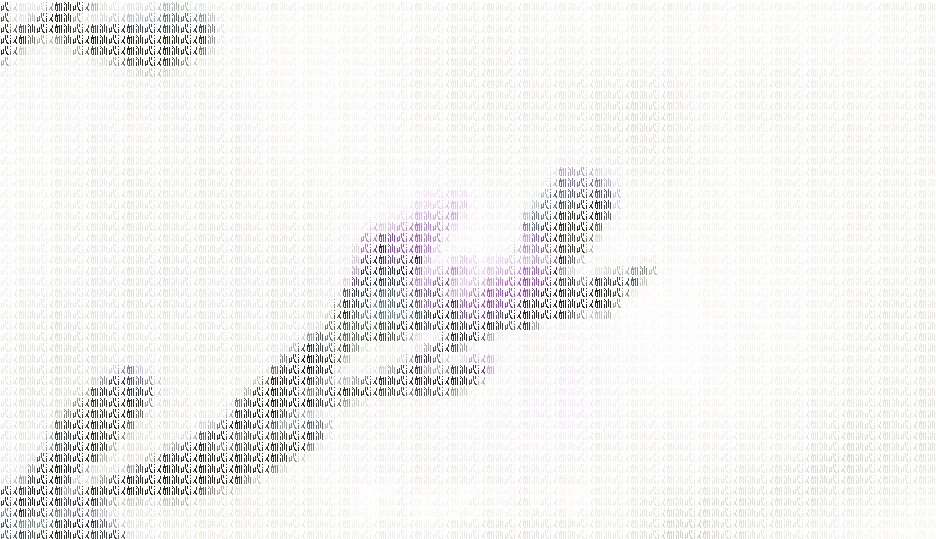

In [8]:
Image.fromarray(cv2.imread(os.path.join(gen_img_dir, "frame_%04d.jpg" % 1)))

## 视频合成
基本思路：创建一个视频文件，逐帧将绘制的图片合成到视频中，最后导出合并完成的视频

In [9]:
def covert_img2video(img_dir, gen_video_path):
    filelist = os.listdir(img_dir)
    filelist.sort() # 将图片名按照从小到大的顺序进行排序
    img = cv2.imread(os.path.join(img_dir, filelist[1]))

    fps = 24  # 视频帧率
    fourcc = cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')  # MP4的编码格式
    size = (img.shape[1], img.shape[0])
    video = cv2.VideoWriter(gen_video_path, fourcc, fps, size)  # size是保存视频的分辨率

    for file_name in filelist:
        if file_name.endswith('.jpg'):
            img = cv2.imread(os.path.join(img_dir, file_name))
            video.write(img)

    video.release()
    print('convert done!')

covert_img2video(gen_img_dir, gen_video_path)

convert done!


# 视频预览
<br/>
<video id="video" width=300 height=170 controls="" preload="none" poster="gen_imgs/frame_0001.jpg">
    <source id="mp4" src="video/video_gen.mp4" type="video/mp4">
</video>

# 技术总结

1. 使用cv2对视频进行切片，得到一帧一帧的源图片，以便后续处理
2. 使用PIL构建文字图，使得目标文字铺满整个图片
3. 读取源图片的像素信息，加到文字图上
4. 将文字图逐帧拼接成完整的视频
***